In [79]:
# Make sure that GPU will be used by clicking "Edit" --> "Notebook Setting"
!pip install SpeechRecognition
!pip install ffmpeg-python
!pip install Levenshtein
!pip3 install torch==1.5.1 torchaudio==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html


In [80]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Learning/EIE558/python-asr/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Learning/EIE558/python-asr


In [81]:
import Levenshtein as Lev
def edit_distance(s1, s2):
    """
    Computes the edit distance between wo sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """
    s1 = s1.lower()
    s2 = s2.lower()
    
    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [31]:
import speech_recognition as sr
import glob
import os

def speech_to_text(sphfile, ambient_period=0):
    r = sr.Recognizer()
    audiofile = sr.AudioFile(sphfile)
    with audiofile as source:
        r.adjust_for_ambient_noise(source, duration=ambient_period)
        speech = r.record(source)
        return(r.recognize_google(speech))

def get_target1(tranfile, key):
    with open(tranfile) as f:
        for line in f:
            fields = line.split(sep=' ', maxsplit=1)
            if key == fields[0]:
                return fields[-1].rstrip()

def get_target2(tranfile):
    with open(tranfile) as f:
        return(f.readline().split(sep=' ', maxsplit=2)[-1].rstrip())
        

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_speech(audio, srate=16000):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,10))
    time = np.arange(audio.shape[0])/srate
    ax1.plot(time, audio)
    ax1.set_xlim([0, time[-1]])
    ax2.specgram(audio, NFFT=512, Fs=srate, noverlap=128)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

In [84]:
from scipy.io import wavfile
import numpy as np

def add_gaussian_noise(input_wav, output_wav, noise_std):
    clean_speech, srate = sf.read(input_wav)
    mu = np.mean(clean_speech)
    sigma = np.std(clean_speech)
    clean_speech = (clean_speech - mu)/sigma
    noise = np.random.normal(0, noise_std, clean_speech.shape[0])
    noisy_speech = np.asarray((clean_speech + noise)*3000, dtype=np.int16)
    wavfile.write(output_wav, srate, noisy_speech)
    return noisy_speech

In [32]:
import numpy as np
filelist = glob.glob('data/**/*.wav', recursive=False)
e_dist = []
n_words = []
for file in filelist:
    rec_text = speech_to_text(file)
    tranfile = file.replace('.wav', '.txt').replace('/speech/','/text/')
    tgt_text = get_target2(tranfile).replace('.', '').replace('?','').replace('!','')
    e_dist.append(edit_distance(rec_text, tgt_text))
    n_words.append(len(tgt_text.split()))
    print(f"Target: {tgt_text.lower()}")
    print(f"Result: {rec_text.lower()}\n")
wer = np.sum(e_dist)/np.sum(n_words) * 100
print("WER = %.2f%%" % wer)

Target: the legislature met to judge the state of public education
Result: the legislature meant to judge the state of public education

Target: who took the kayak down the bayou
Result: who took the kayak down the by you

WER = 17.65%


In [72]:
filelist = glob.glob('data/**/*.flac', recursive=False)
tranfile = "data/text/1272-128104.trans.txt"
e_dist = []
n_words = []
for file in filelist:
    base = os.path.basename(file)
    key = base.replace('.flac', '')
    rec_text = speech_to_text(file)
    tgt_text = get_target1(tranfile, key).replace('.', '').replace('?','').replace('!','')
    e_dist.append(edit_distance(rec_text, tgt_text))
    n_words.append(len(tgt_text.split()))
    print(f"Target: {tgt_text.lower()}")
    print(f"Result: {rec_text.lower()}\n")
wer = np.sum(e_dist)/np.sum(n_words) * 100
print("WER = %.2f%%" % wer)

Target: mister quilter has missed his chance for he has failed even to make himself the tupper of painting
Result: mr. kruger has missed his chance for he has failed even to make himself at upper of painting

Target: he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures makes the customary appeal to the last judgment and reminds us that in the great days of art michael angelo was the furnishing upholsterer
Result: she laments most bitterly the divorce that has been made between decorative art and what we usually call pictures makes a customary appeal to the last judgment and reminds us that integrate days of art michelangelo was the furnishing upholsterer

Target: mister quilter is the apostle of the middle classes and we are glad to welcome his gospel
Result: mister quilter is the apostle of the middle classes and we are glad to welcome his gospel

Target: he tells us that at this festive season of the year with christmas and 

In [41]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 16000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Please say: Speech recognition is fun


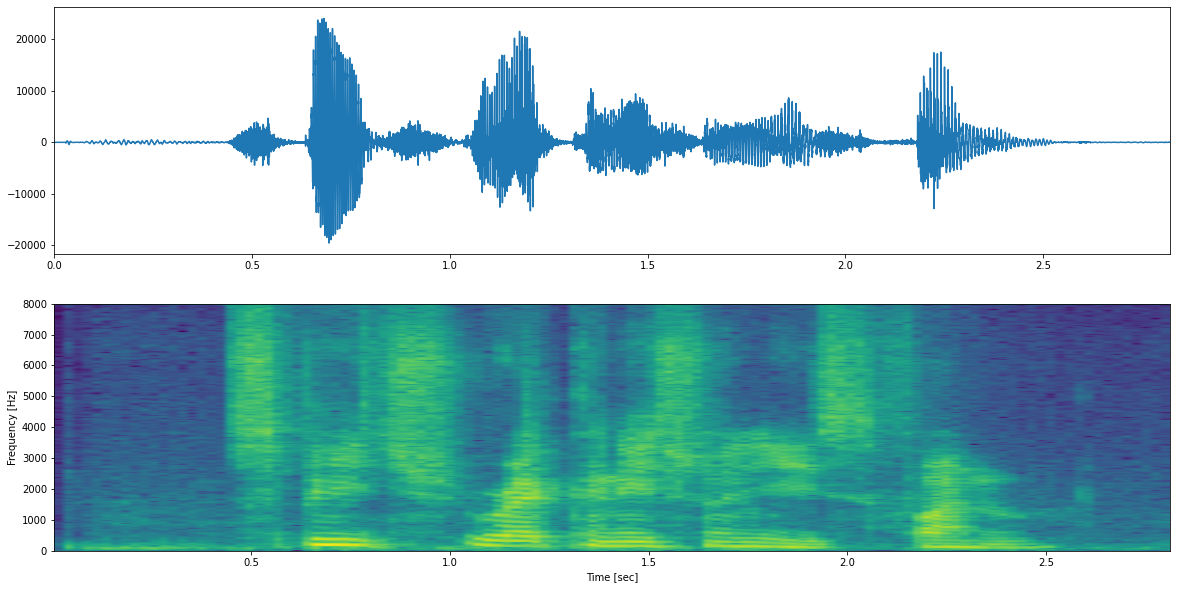

In [100]:
import scipy.signal as sps
from scipy.io import wavfile
tgt_text = "Speech recognition is fun"
print(f"Please say: {tgt_text}")
audio, srate = get_audio()
n_samples = round(len(audio) * float(16000) / srate)
audio = sps.resample(audio, n_samples)
srate = 16000
wavfile.write("./test_clean.wav", srate, audio.astype(np.int16))
plot_speech(audio)

In [101]:
rec_text = speech_to_text("./test_clean.wav")
wer = edit_distance(tgt_text, rec_text)/len(tgt_text.split()) * 100
print(f"Target: {tgt_text.lower()}")
print(f"Result: {rec_text.lower()}")
print("WER = %.2f%%" % wer)

Target: speech recognition is fun
Result: speech recognition is fun
WER = 0.00%


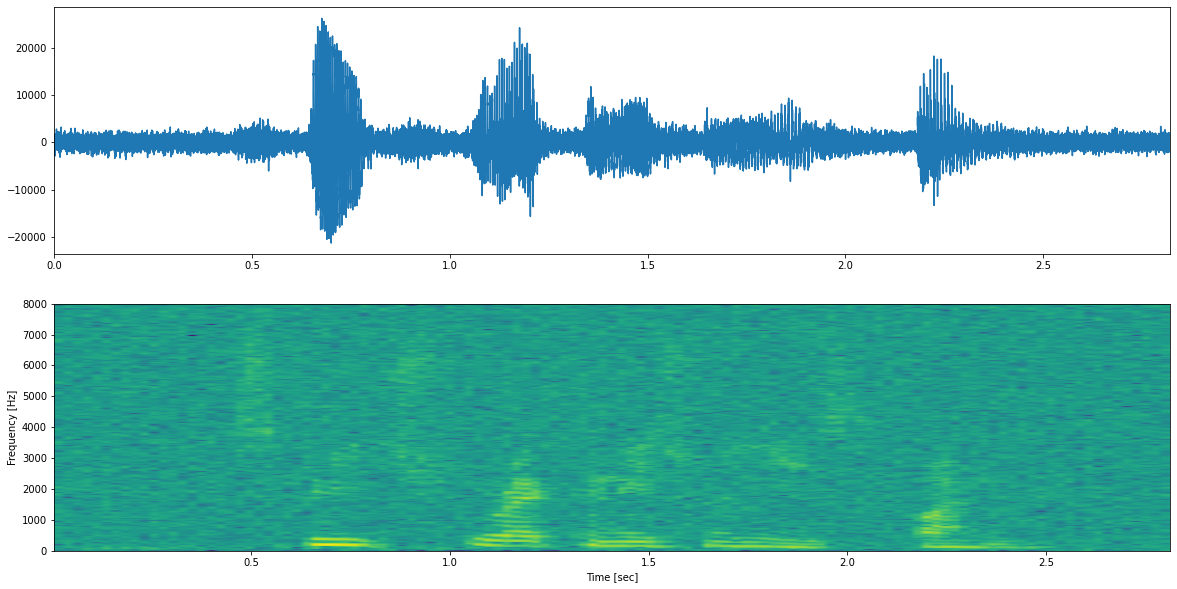

In [105]:
noisy_speech = add_gaussian_noise(input_wav='./test_clean.wav', output_wav='./test_noisy.wav', noise_std=0.3)
plot_speech(noisy_speech)

In [103]:
from IPython.display import Audio
Audio(noisy_speech, rate=srate)

In [106]:
rec_text = speech_to_text("./test_noisy.wav", ambient_period=0)
wer = edit_distance(tgt_text, rec_text)/len(tgt_text.split()) * 100
print(f"Target: {tgt_text.lower()}")
print(f"Result: {rec_text.lower()}")
print("WER = %.2f%%" % wer)

Target: speech recognition is fun
Result: speech recognition in spanish
WER = 50.00%


In [107]:
!ls ../DCUnet16/dc-unet_test.py

../DCUnet16/dc-unet_test.py


In [110]:
%cd ../DCUnet16
!python3 dc-unet_test.py --noised_wav ../python-asr/test_noisy.wav --denoised_wav ../python-asr/test_denoised.wav
%cd ../python-asr

/content/drive/My Drive/Learning/EIE558/DCUnet16
Test mode
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
/content/drive/My Drive/Learning/EIE558/python-asr


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


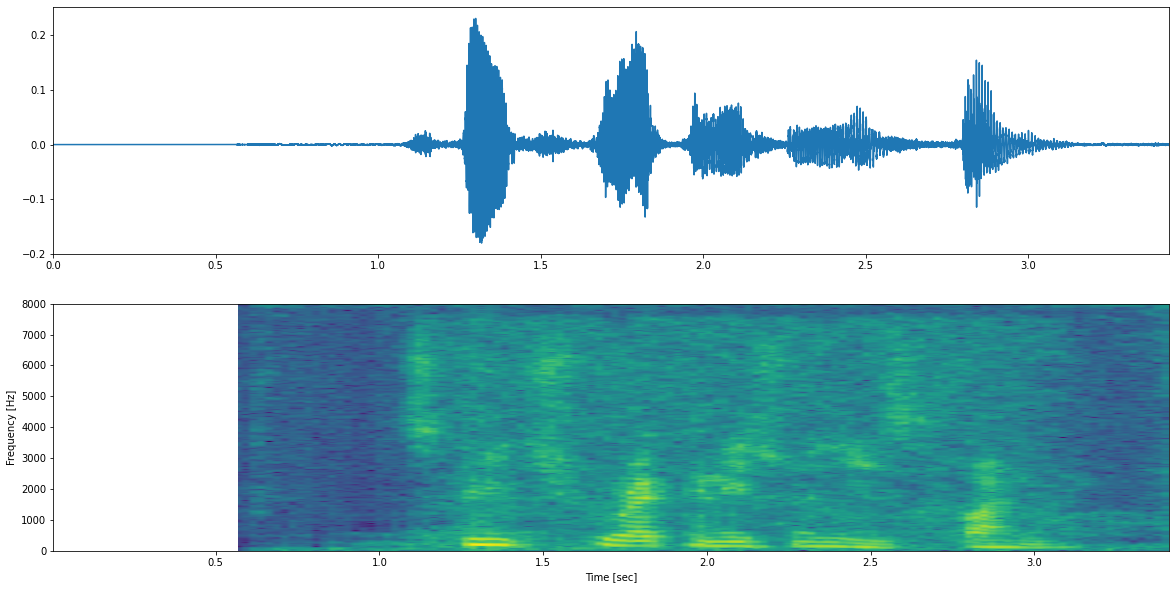

In [111]:
# Denoised speech
import soundfile as sf
from scipy.io import wavfile
denoised_speech, srate = sf.read('./test_denoised.wav')
plot_speech(denoised_speech)

In [112]:
from IPython.display import Audio
Audio(denoised_speech, rate=srate)

In [119]:
rec_text = speech_to_text("./test_denoised.wav")
wer = edit_distance(tgt_text, rec_text)/len(tgt_text.split()) * 100
print(f"Target: {tgt_text.lower()}")
print(f"Result: {rec_text.lower()}")
print("WER = %.2f%%" % wer)

Target: speech recognition is fun
Result: speech recognition
WER = 50.00%
